In [1]:
# importing required library to perform feature selection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# importing the dataset
input_file = "chowdary.csv"
df = pd.read_csv(input_file)

# seperating the independent and dependent variables
X = df.iloc[:, 3:]
Y = df.iloc[:, 1]

# splitting the dataset into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Convert back to DataFrame
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X_test.columns)

# summarizing the dataset
# number of 'B' and 'C' in training and testing set
print("The number of 'B' and 'C' in training set: ", Y_train.value_counts())
print("The number of 'B' and 'C' in testing set: ", Y_test.value_counts())
print("The shape of the training set is: ", X_train_normalized_df.shape)
print("The shape of the testing set is: ", X_test_normalized_df.shape)

The number of 'B' and 'C' in training set:  tumour
B    52
C    31
Name: count, dtype: int64
The number of 'B' and 'C' in testing set:  tumour
C    11
B    10
Name: count, dtype: int64
The shape of the training set is:  (83, 181)
The shape of the testing set is:  (21, 181)


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the Random Forest classifier
rf = RandomForestClassifier()

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
}

# Create the GridSearchCV object
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search_rf.fit(X_train_normalized_df, Y_train)

# Print the best hyperparameters
print("Best parameters: ", grid_search_rf.best_params_)

Best parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from scipy.stats import randint

# Range of k values to test
k_values = list(range(1, X_train_normalized_df.shape[1] + 1))

# Parameter distributions for the random search
param_distributions = {
    'classifier__n_estimators': randint(50, 200),
    'classifier__max_depth': randint(5, 20),
    'classifier__min_samples_leaf': randint(1, 10),
    'selectkbest__k': k_values
}

# Create a pipeline with feature selection and classifier
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('selectkbest', SelectKBest(mutual_info_classif)),
    ('classifier', RandomForestClassifier())
])

# Initialize the random search with cross-validation
cv = StratifiedKFold(n_splits=10)
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_distributions, n_iter=100, cv=cv, scoring='accuracy', n_jobs=-1
)

# Fit the random search to the training data
random_search.fit(X_train_normalized_df, Y_train)

# Print the best parameters and score
print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

# Get the final selected features
best_k = random_search.best_params_['selectkbest__k']
selector = SelectKBest(mutual_info_classif, k=best_k)
selector.fit(X_train_normalized_df, Y_train)
selected_indices = selector.get_support(indices=True)
selected_features = X_train_normalized_df.columns[selected_indices]
print("Selected features: ", selected_features)

# Transform the datasets using the selected features
X_train_selected = selector.transform(X_train_normalized_df)
X_test_selected = selector.transform(X_test_normalized_df)

Best parameters:  {'classifier__max_depth': 11, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 73, 'selectkbest__k': 168}
Best score:  0.9625
Selected features:  Index(['X201262_s_at', 'X201496_x_at', 'X201497_x_at', 'X201525_at',
       'X201884_at', 'X201909_at', 'X202018_s_at', 'X202037_s_at',
       'X202286_s_at', 'X202376_at',
       ...
       'X219404_at', 'X219508_at', 'X219580_s_at', 'X219768_at',
       'X221004_s_at', 'X221245_s_at', 'X221879_at', 'X37892_at',
       'X44790_s_at', 'X60474_at'],
      dtype='object', length=168)


              precision    recall  f1-score   support

           B       0.91      1.00      0.95        10
           C       1.00      0.91      0.95        11

    accuracy                           0.95        21
   macro avg       0.95      0.95      0.95        21
weighted avg       0.96      0.95      0.95        21

          feature  importance
0    X201262_s_at    0.000000
1    X201496_x_at    0.002421
2    X201497_x_at    0.001458
3      X201525_at    0.002250
4      X201884_at    0.029571
..            ...         ...
163  X221245_s_at    0.009171
164    X221879_at    0.044390
165     X37892_at    0.000000
166   X44790_s_at    0.000000
167     X60474_at    0.027545

[168 rows x 2 columns]


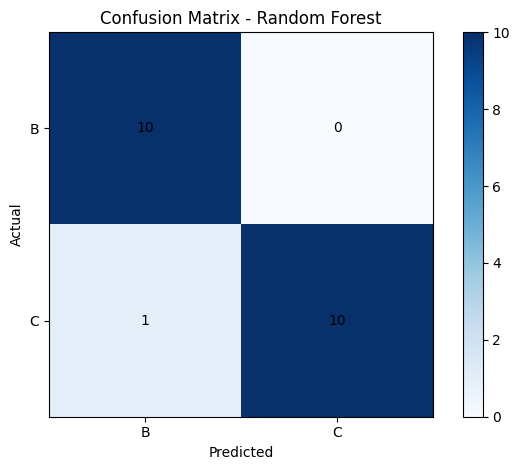

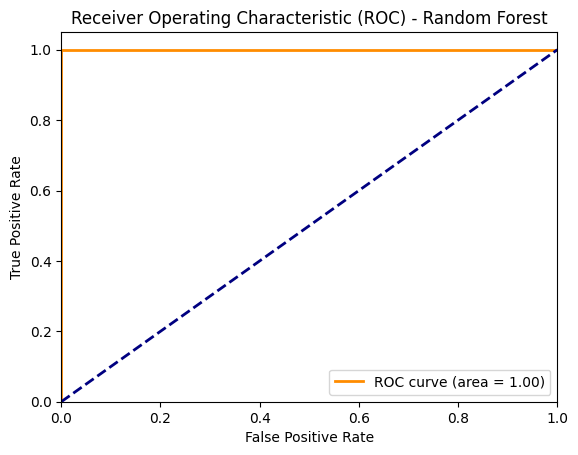

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc

X_train_rf = X_train[selected_features]
X_test_rf = X_test[selected_features]

# Fit the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=1)
rf.fit(X_train_rf, Y_train)

# Make predictions
Y_pred_rf = rf.predict(X_test_rf)
Y_pred_proba_rf = rf.predict_proba(X_test_rf)[:, 1]

# Print classification report
print(classification_report(Y_test, Y_pred_rf))

# Print feature importances
importances = pd.DataFrame({'feature': selected_features, 'importance': rf.feature_importances_})
print(importances)

# Confusion matrix
conf_mat_rf = confusion_matrix(Y_test, Y_pred_rf)
plt.imshow(conf_mat_rf, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(len(conf_mat_rf)):
    for j in range(len(conf_mat_rf[0])):
        plt.text(j, i, str(conf_mat_rf[i][j]), horizontalalignment='center', verticalalignment='center')
tick_marks = np.arange(len(np.unique(df['tumour'])))
plt.xticks(tick_marks, np.unique(df['tumour']))
plt.yticks(tick_marks, np.unique(df['tumour']))
plt.tight_layout()
plt.show()

# ROC curve
fpr_rf, tpr_rf, _ = roc_curve(Y_test, Y_pred_proba_rf, pos_label=df['tumour'].unique()[1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc="lower right")
plt.show()

In [4]:
# Calculate the log-likelihood
log_likelihood = rf.predict_log_proba(X_train_selected).sum()

# Calculate the number of parameters (k) and samples (n)
k = len(selected_features) + 1  # Add 1 for the intercept
n = X_train_selected.shape[0]

# Calculate AIC and BIC
aic = -2 * log_likelihood + 2 * k
bic = -2 * log_likelihood + k * np.log(n)

print("AIC: ", aic)
print("BIC: ", bic)

AIC:  600.3405343814333
BIC:  1009.1245970990584


d:\TCD\Term2\applied-statistics\main\my_env\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [18]:
importances.to_csv('rf_importances.csv', index=False)